## **#05. Recurrent Neural Networks and Text Mining**
- Instructor: [Jaeung Sim](https://jaeungs.github.io/) (University of Connecticut)
- Course: OPIM 5671 Data Mining and Time Series Forecasting
- Last updated: September 23, 2025

**Objectives**
* Build a natural language processing (NLP) model with recurrent neural networks (RNNs) to classify texts.

**References**
* [Deep Learning Basics by Google Colab](https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb)
* [Text classification with an RNN by TensorFlow](https://www.tensorflow.org/text/tutorials/text_classification_rnn)
* [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)
* [Masking and padding with Keras by TensorFlow](https://www.tensorflow.org/guide/keras/masking_and_padding)

#### **Text Classification of IMDb Movie Reviews with RNNs**

In this practice, you will train a RNN model on the [IMDb large movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

This dataset is constructed for binary sentiment classification and provides a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided.

##### **1. Setup**

In [ ]:
# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
# Create a helper function to plot graphs using `matplotlib`
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

The IMDb large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment. Let's download the dataset using `tfds`.

In [ ]:
# Load the dataset
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Return a dataset of (text, label) pairs
for example, label in train_dataset.take(3): # No. of examples
  print('Text: ', example.numpy())
  print('Label: ', label.numpy())

Text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label:  0
Text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

Next shuffle the data for training and create batches of these `(text, label)` pairs.

**FYI: Buffer Size vs. Batch Size**
* The **buffer size** refers to the number of elements from the dataset that the data loader should prefetch in memory in order to speed up data loading. This is typically used when the dataset is too large to fit entirely in memory and needs to be loaded from disk or a remote location. A larger buffer size can lead to faster data loading, but can also consume more memory.
* The **batch size**, on the other hand, refers to the number of samples that are processed by the model at once during each training iteration. In other words, the batch size determines how many samples are used to calculate the gradients that update the model's parameters. A larger batch size can lead to faster training, but can also require more memory and result in less accurate gradients due to increased noise.

In [ ]:
# Set the buffer and batch sizes
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Apply buffer and batch sizes to datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Print some examples from the shuffled dataset
for example, label in train_dataset.take(1):
  print('Texts: ', example.numpy()[:3])
  print()
  print('Labels: ', label.numpy()[:3])

Texts:  [b'Since this picture is classified a "pure entertainment" work and since there are already many comments on it, I\'d like hereby to address something relevant to the abuse of humour. We can see that Marlon Wayans is playing the joker role in this film. Certainly as long as he has been involved in the casting job, he has always been acting as a little man-an actor can change his customary dress but can hardly change his physical appearance-and the latter one can be an advantage when necessary. However far away from what I expected, I saw an image very disguising, pretending to expose different aspects of the baby life by mistake of a forty-year- old criminal. And with a ridiculous happy ending. So what is the point? Many elements are mixed up, some principal ones are violence, sex and criminal activities, amongst which the story is badly composed and to some extent, lack common sense: where is Vanessa when the peace of her house is violated and her husband\'s life being pursued

##### **2. Building and Training the Model**

**A. Create the text encoder**

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this practice sticks to the default behavior.

The following code creates a text encoder using the `TextVectorization` layer in TensorFlow as follows (see <https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization> for details):

1. The `max_tokens` parameter sets the maximum size of the vocabulary to be used by the encoder. In this case, it is set to 1000.

1. The `adapt` method is called on the encoder object to build the vocabulary based on the training dataset. The `map` function is used to extract only the text data from the dataset, which is then passed to the `adapt` method. This allows the encoder to learn the vocabulary from the text data and create a mapping between words and integer indices.

1. After the vocabulary has been built, the encoder can be used to transform the text data into a sequence of integer indices that can be fed into a neural network.

In [ ]:
# Create a text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[231,  11, 433, ...,   0,   0,   0],
       [ 11,  14,  38, ...,   0,   0,   0],
       [110, 208,   2, ...,   0,   0,   0]])

The `[UNK]` token serves as a placeholder for words that are not found in the model's vocabulary during either training or inference.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Since this picture is classified a "pure entertainment" work and since there are already many comments on it, I\'d like hereby to address something relevant to the abuse of humour. We can see that Marlon Wayans is playing the joker role in this film. Certainly as long as he has been involved in the casting job, he has always been acting as a little man-an actor can change his customary dress but can hardly change his physical appearance-and the latter one can be an advantage when necessary. However far away from what I expected, I saw an image very disguising, pretending to expose different aspects of the baby life by mistake of a forty-year- old criminal. And with a ridiculous happy ending. So what is the point? Many elements are mixed up, some principal ones are violence, sex and criminal activities, amongst which the story is badly composed and to some extent, lack common sense: where is Vanessa when the peace of her house is violated and her husband\'s life being pursu

**B. Create the model**

![image](https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.

The code to implement this is below:

In [ ]:
# Build the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

**FYI: Masking and Padding**
* **Masking** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.
* **Padding** is a special form of masking where the masked steps are at the start or the end of a sequence. Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.

**Example of Padding Sequence Data with Tokenized Texts**

```
[
  ["Hello", "world", "!"],
  ["How", "are", "you", "doing", "today"],
  ["The", "weather", "will", "be", "nice", "tomorrow"],
]
```

After vocabulary lookup, the data might be vectorized as integers like:

```
[
  [71, 1331, 4231]
  [73, 8, 3215, 55, 927],
  [83, 91, 1, 645, 1253, 927],
]
```

The data is a nested list where individual samples have length 3, 5, and 6, respectively. Since the input data for a deep learning model must be a single tensor (of shape e.g., `(batch_size, 6, vocab_size)` in this case), samples that are shorter than the longest item need to be padded with some placeholder value (alternatively, one might also truncate long samples before padding short samples).

Keras provides a utility function to truncate and pad Python lists to a common length: `tf.keras.preprocessing.sequence.pad_sequences`. By using this function, you may convert raw vectors into the following padded outcomes:

```
[[ 711  632   71    0    0    0]
 [  73    8 3215   55  927    0]
 [  83   91    1  645 1253  927]]
```

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the embedding support masking.

In [ ]:
# Check if each layer supports masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**C. Train the model**

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Train the RNN model
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.5131 - loss: 0.6826 - val_accuracy: 0.6807 - val_loss: 0.4854
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.8042 - loss: 0.4190 - val_accuracy: 0.8401 - val_loss: 0.3688
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.8425 - loss: 0.3648 - val_accuracy: 0.8526 - val_loss: 0.3429


In [ ]:
# Assess the model statistics
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 149s 380ms/step - accuracy: 0.8552 - loss: 0.3383
Test Loss: 0.33692803978919983
Test Accuracy: 0.855679988861084


(0.0, 0.8667283594608307)

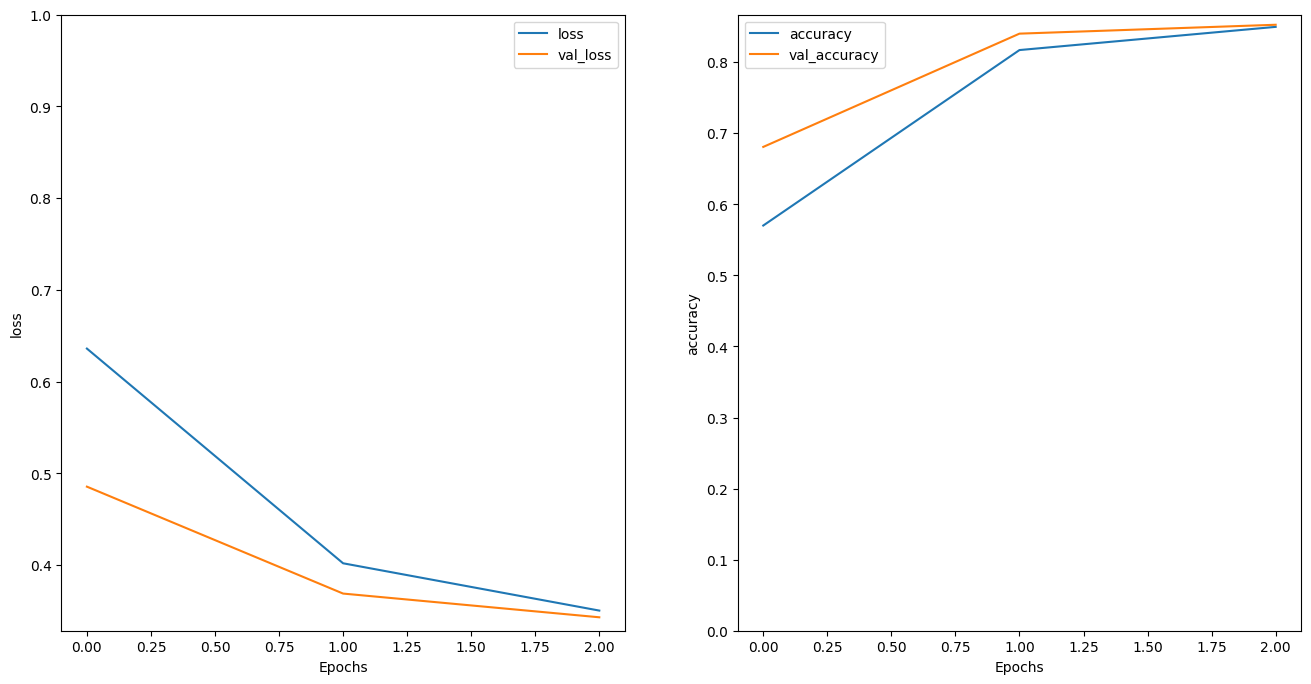

In [ ]:
# Visualize the history of loss and accuracy by epoch
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'loss')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is $\ge 0.0$, it is positive else it is negative.

In [ ]:
# Predict on a new sample sentence (this code worked last year but not anymore)
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

ValueError: Invalid dtype: str3328

In [ ]:
# Predict on a new sample sentence
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
# Convert the sample text to a tf.Tensor before prediction
input_text = tf.constant([sample_text])
predictions = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step


In [ ]:
predictions

array([[0.71263367]], dtype=float32)

**D. Build and train the model by staking two or more LSTM layers**

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (`batch_size, output_features`)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![image](https://www.tensorflow.org/static/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an RNN with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
# Define the RNN architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Train the model (only 1 epoch for the time being)
history = model.fit(train_dataset, epochs=1, # Increase epochs if you want
                    validation_data=test_dataset,
                    validation_steps=30)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1282s 3s/step - accuracy: 0.5234 - loss: 0.6793 - val_accuracy: 0.7479 - val_loss: 0.5279


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 255s 653ms/step - accuracy: 0.7449 - loss: 0.5207
Test Loss: 0.5185953974723816
Test Accuracy: 0.7450399994850159


In [ ]:
# Visualize the results (run if you ran the model 'history' with 3 epochs)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'loss')
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')